In [5]:
import pandas as pd
import numpy as np

from statsmodels.tsa.stattools import adfuller
import statsmodels.api as sm

from scipy import stats
import matplotlib.pyplot as plt
from scipy.stats import norm, multivariate_normal
from scipy.optimize import minimize


### Setup: Load & merge the data on date

In [6]:
# Load CSVs (adjust paths if needed)
beef = pd.read_csv("data/beefprice.csv", parse_dates=["observation_date"])
corn = pd.read_csv("data/cornprice.csv", parse_dates=["observation_date"])
soy  = pd.read_csv("data/soybeanprice.csv", parse_dates=["observation_date"])


# Rename columns to simple names (change keys if CSV uses other column names)
beef = beef.rename(columns={"PBEEFUSDM": "beef"})
corn = corn.rename(columns={"PMAIZMTUSDM": "corn"})
soy  = soy.rename(columns={"PSMEAUSDM": "soybean"})

for df in (beef, corn, soy):
    df["observation_date"] = pd.to_datetime(df["observation_date"])

# Merge on date, set index
df = (
    beef.merge(corn, on="observation_date")
        .merge(soy,  on="observation_date")
        .set_index("observation_date")
        .sort_index()
)

print(df.head())


                        beef        corn     soybean
observation_date                                    
1990-01-01        126.309998  105.900513  191.306128
1990-02-01        111.459991  106.294167  182.267175
1990-03-01        112.670013  109.837318  184.328497
1990-04-01        112.129997  118.498337  191.063619
1990-05-01        112.489990  121.254097  199.970295


### Check stationarity & transform if needed

In [7]:
for col in ["beef", "corn", "soybean"]:
    result = adfuller(df[col])
    print(col, "ADF p-value:", result[1])

beef ADF p-value: 0.9944272260880761
corn ADF p-value: 0.17685804601635507
soybean ADF p-value: 0.39031170788204866


ADF test on the price levels yields p-values > 0.05, meaning we cannot reject the presence of a unit root. Thus, the series are non-stationary.
Hence, we perform the correct transformation:log + difference to make the series stationary.

In [8]:
df["ln_beef"] = np.log(df["beef"])
df["ln_corn"] = np.log(df["corn"])
df["ln_soy"]  = np.log(df["soybean"])

df_ret = df[["ln_beef", "ln_corn", "ln_soy"]].diff().dropna()

df_ret.columns = ["r_beef", "r_corn", "r_soy"]

for col in df_ret.columns:
    result = adfuller(df_ret[col])
    print(col, "ADF p-value:", result[1])

r_beef ADF p-value: 3.7157360613875612e-09
r_corn ADF p-value: 7.338705406422303e-12
r_soy ADF p-value: 1.5740872377441988e-25


We now conclude that these log returns are stationary.

### Pairwise correlation matrix

In [9]:
# Pairwise correlation matrix of log returns 
corr_matrix = df_ret.corr()
corr_matrix

,r_beef,r_corn,r_soy
r_beef,1.000000,0.057078,0.060299
r_corn,0.057078,1.000000,0.490252
r_soy,0.060299,0.490252,1.000000


In [10]:
covar_matrix = df_ret.cov()
covar_matrix

,r_beef,r_corn,r_soy
r_beef,0.001710,0.000137,0.000155
r_corn,0.000137,0.003377,0.001771
r_soy,0.000155,0.001771,0.003864


### Dependence Analysis
Beef ↔ Corn

Beef ↔ Soybean Meal

Beef ↔ (Corn + Soybean Meal jointly)

but for Session 1 we still analyze pairwise, so do:

Beef ↔ Corn

Beef ↔ Soybean

##### summary statistics, skewness and kurtosis

In [11]:
skew = df_ret.apply(stats.skew)
kurt = df_ret.apply(lambda x: stats.kurtosis(x, fisher=False))

summary = pd.DataFrame({
    "Mean": df_ret.mean(),
    "Std Dev": df_ret.std(),
    "Min": df_ret.min(),
    "Max": df_ret.max(),
    "Skewness": df_ret.apply(stats.skew),
    "Kurtosis": df_ret.apply(lambda x: stats.kurtosis(x, fisher=False))
})

print(summary)

            Mean   Std Dev       Min       Max  Skewness  Kurtosis
r_beef  0.002022  0.041347 -0.179663  0.193878  0.139789  6.223785
r_corn  0.001445  0.058109 -0.251764  0.219659 -0.311423  5.051234
r_soy   0.001159  0.062157 -0.316084  0.217934 -0.238644  5.002901


In [12]:
pair_list = {
    "beef_corn": df_ret[["r_beef", "r_corn"]],
    "beef_soy":  df_ret[["r_beef", "r_soy"]],
    "corn_soy": df_ret[["r_corn", "r_soy"]]   # for exploration, take out if not needed
}

Pipeline to call for all 3 pairs

In [25]:
def analyze_pair(df_pair, name="Pair"):
    print(f"\n\n==================== {name} ====================\n")

    x, y = df_pair.columns

    # === Summary stats ===
    print("Summary Statistics:")
    print(df_pair.describe().T)
    print("\nCovariance:\n", df_pair.cov())
    print("\nCorrelation:\n", df_pair.corr())

    # === Normality tests ===
    print("\nNormality (Jarque-Bera):")
    for col in df_pair.columns:
        stat, p = stats.jarque_bera(df_pair[col])
        print(f"{col}: p = {p}")

    # === MGF ===
    print("\nEmpirical MGF (t = -0.5 to 0.5):")
    t_vals = np.linspace(-0.5, 0.5, 5)
    for col in df_pair.columns:
        print(f"\nMGF for {col}:")
        for t in t_vals:
            print(f"t = {t:.2f}: {np.mean(np.exp(t * df_pair[col])):.4f}")

    # === Histogram + KDE + Normal PDF ===
    for col in df_pair.columns:
        data = df_pair[col]
        mean = data.mean()
        std  = data.std()

        xs = np.linspace(data.min(), data.max(), 300)
        kde = stats.gaussian_kde(data)

        plt.figure(figsize=(7,4))
        plt.hist(data, bins=30, density=True, alpha=0.5, label="Histogram")
        plt.plot(xs, kde(xs), label="KDE", linewidth=2)

        # Normal PDF using sample mean & std
        normal_pdf = norm.pdf(xs, mean, std)
        plt.plot(xs, normal_pdf, 'r--', linewidth=2, label="Normal PDF")

        plt.title(f"{col}: Empirical Distribution vs Normal")
        plt.xlabel(col)
        plt.ylabel("Density")
        plt.legend()
        plt.show()

    # === Plots ===
    df_pair.hist(bins=30, figsize=(7,4))
    plt.suptitle(f"Histograms for {name}")
    plt.show()

    for col in df_pair.columns:
        sm.qqplot(df_pair[col], line="s")
        plt.title(f"Q-Q Plot for {col}")
        plt.show()

    # === Integral transform ===
    U = df_pair.rank() / (len(df_pair) + 1)
    U.columns = ["U1", "U2"]

    plt.scatter(U["U1"], U["U2"], s=10, alpha=0.5)
    plt.title(f"Pseudo-observations: {name}")
    plt.xlabel(df_pair.columns[0])
    plt.ylabel(df_pair.columns[1])
    plt.show()

    # === Rank dependence ===
    tau, _ = stats.kendalltau(df_pair.iloc[:,0], df_pair.iloc[:,1])
    rho_s, _ = stats.spearmanr(df_pair.iloc[:,0], df_pair.iloc[:,1])
    print("\nRank dependence:")
    print("Kendall tau:", tau)
    print("Spearman rho:", rho_s)

    # === Copula estimation ===
    # Prep
    u = U["U1"].values
    v = U["U2"].values
    n  = len(U)
    k = 1
    #guassian copula MLE
    z1 = norm.ppf(U["U1"])
    z2 = norm.ppf(U["U2"])
    Z = np.column_stack([z1, z2])

    def negloglik_guassian(theta):
        rho = theta[0]
        if abs(rho) >= 0.999:
            return 1e10
        cov = [[1, rho], [rho, 1]]
        mvn = multivariate_normal(cov=cov)
        log_joint = mvn.logpdf(Z)
        log_marg = norm.logpdf(z1) + norm.logpdf(z2)
        return -(log_joint - log_marg).sum()

    res_gauss = minimize(negloglik_guassian, x0=[0.2], bounds=[(-0.99, 0.99)])
    rho_hat = res_gauss.x[0]
    ll_gauss = -res_gauss.fun
    aic_gauss = 2*k - 2*ll_gauss
    bic_gauss = k*np.log(n) - 2*ll_gauss

    #clayton copula MLE
    def clayton_copula_logpdf(u, v, theta):
        return (
            np.log(theta + 1)
            + (-theta - 1) * (np.log(u) + np.log(v))
            - (2 + 1/theta) * np.log(u**(-theta) + v**(-theta) - 1)
        )

    def negloglik_clayton(theta):
        if theta[0] <= 0:
            return 1e10
        t = theta[0]
        return -np.sum(clayton_copula_logpdf(u, v, t))

    res_clayton = minimize(negloglik_clayton, x0=[1.0], bounds=[(1e-4, None)])
    theta_c = res_clayton.x[0]
    ll_clayton = -res_clayton.fun
    aic_clayton = 2*k - 2*ll_clayton
    bic_clayton = np.log(n)*k - 2*ll_clayton

    #gumbel copula MLE
    def gumbel_logpdf(u, v, theta):
        if theta < 1:
            return -np.inf
        A = ((-np.log(u))**theta + (-np.log(v))**theta)**(1/theta)
        return (
            -A
            + (theta - 1)*(np.log(-np.log(u)) + np.log(-np.log(v)))
            - (2 - 1/theta)*np.log(A)
            - np.log(u*v)  # Jacobian
        )

    def negloglik_gumbel(theta):
        if theta[0] < 1:
            return 1e10
        t = theta[0]
        return -np.sum(gumbel_logpdf(u, v, t))

    res_gumbel = minimize(negloglik_gumbel, x0=[1.5], bounds=[(1.0, None)])
    theta_g = res_gumbel.x[0]
    ll_gumbel = -res_gumbel.fun
    aic_gumbel = 2*k - 2*ll_gumbel
    bic_gumbel = np.log(n)*k - 2*ll_gumbel

    # Summary table of Copula results
    print("\nCopula Model Comparison:")
    print(f"{'Model':<12} {'Param':<12} {'LogLik':<12} {'AIC':<12} {'BIC':<12}")
    print(f"{'Gaussian':<12} {rho_hat:<12.4f} {ll_gauss:<12.4f} {aic_gauss:<12.4f} {bic_gauss:<12.4f}")
    print(f"{'Clayton':<12} {theta_c:<12.4f} {ll_clayton:<12.4f} {aic_clayton:<12.4f} {bic_clayton:<12.4f}")
    print(f"{'Gumbel':<12} {theta_g:<12.4f} {ll_gumbel:<12.4f} {aic_gumbel:<12.4f} {bic_gumbel:<12.4f}")


In [ ]:
from scipy.stats import jarque_bera
jb_results = {}
for col in df_ret.columns:
    stat, p = jarque_bera(df_ret[col])
    jb_results[col] = (stat, p)
jb_table = pd.DataFrame(jb_results, index=["JB Statistic", "p-value"]).T
print(jb_table)


        JB Statistic  p-value
r_beef    185.423088      0.0
r_corn     81.378606      0.0
r_soy      75.072987      0.0


In [29]:
t_val = np.linspace(-0.5, 0.5, 5)
mgf_results = {}

for col in df_ret.columns:   # r_beef, r_corn, r_soy
    mgf_results[col] = [np.mean(np.exp(t * df_ret[col])) for t in t_val]

# Create table
mgf_table = pd.DataFrame(mgf_results, index=[f"t = {t:.2f}" for t in t_val])

print(mgf_table)

             r_beef    r_corn     r_soy
t = -0.50  0.999202  0.999700  0.999903
t = -0.25  0.999548  0.999744  0.999831
t = 0.00   1.000000  1.000000  1.000000
t = 0.25   1.000559  1.000467  1.000410
t = 0.50   1.001225  1.001143  1.001061




==================== Beef vs Corn ====================

Summary Statistics:
        count      mean       std       min       25%       50%       75%  \
r_beef  425.0  0.002022  0.041347 -0.179663 -0.018924  0.003186  0.022118   
r_corn  425.0  0.001445  0.058109 -0.251764 -0.028591  0.001687  0.036196   

             max  
r_beef  0.193878  
r_corn  0.219659  

Covariance:
           r_beef    r_corn
r_beef  0.001710  0.000137
r_corn  0.000137  0.003377

Correlation:
           r_beef    r_corn
r_beef  1.000000  0.057078
r_corn  0.057078  1.000000

Normality (Jarque-Bera):
r_beef: p = 0.0
r_corn: p = 0.0

Empirical MGF (t = -0.5 to 0.5):

MGF for r_beef:
t = -0.50: 0.9992
t = -0.25: 0.9995
t = 0.00: 1.0000
t = 0.25: 1.0006
t = 0.50: 1.0012

MGF for r_corn:
t = -0.50: 0.9997
t = -0.25: 0.9997
t = 0.00: 1.0000
t = 0.25: 1.0005
t = 0.50: 1.0011


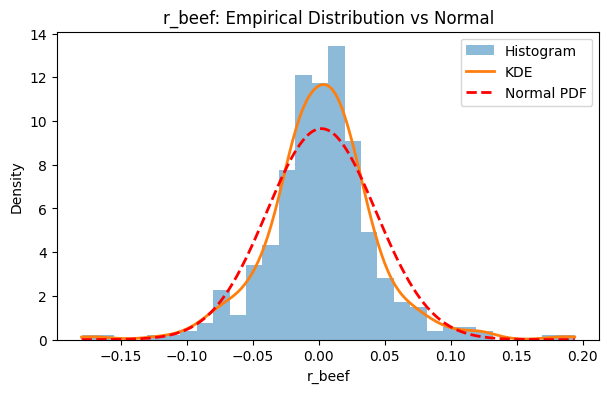

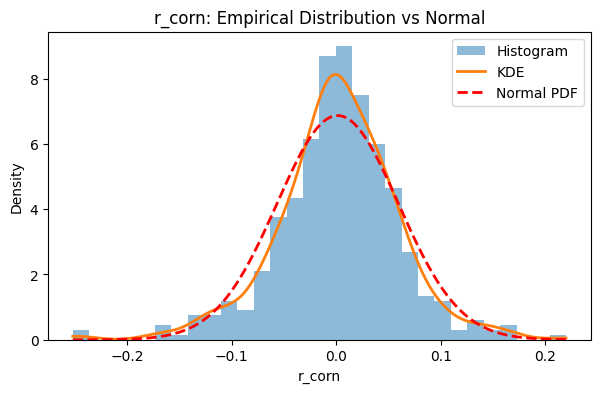

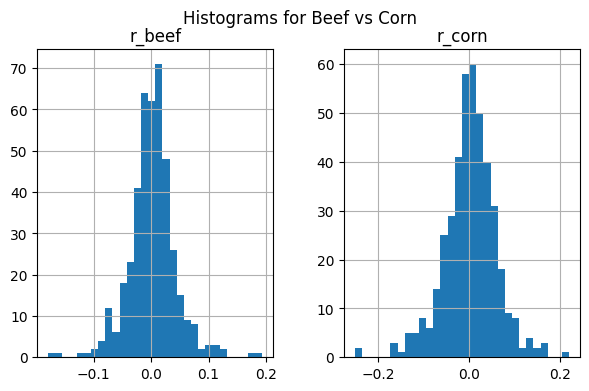

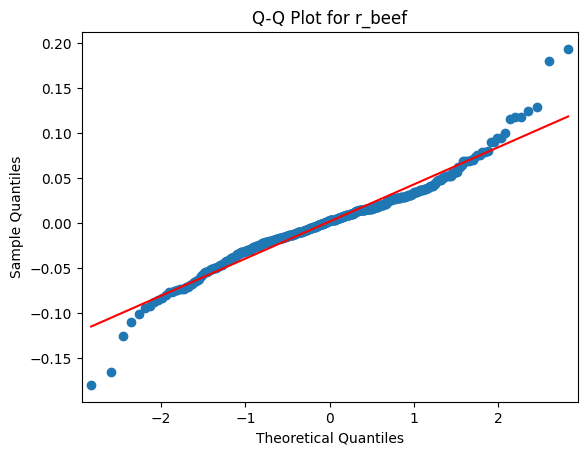

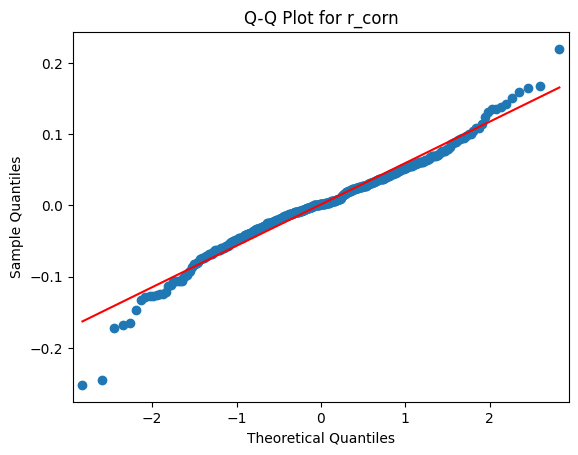

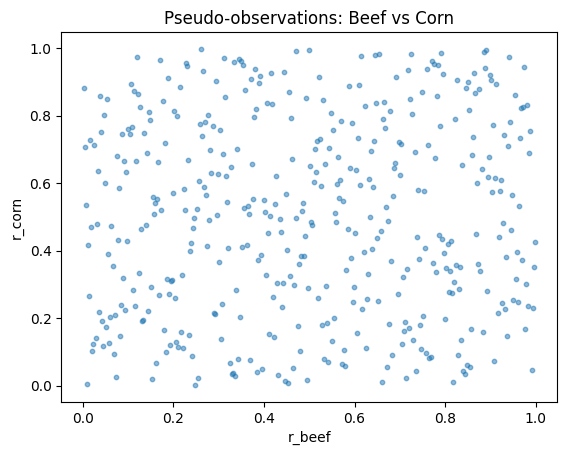


Rank dependence:
Kendall tau: 0.027558421523296284
Spearman rho: 0.04253255547562788

Copula Model Comparison:
Model        Param        LogLik       AIC          BIC         
Gaussian     0.0561       0.6380       0.7239       4.7760      
Clayton      0.0506       0.4544       1.0912       5.1432      
Gumbel       1.0000       -174.5069    351.0138     355.0659    


==================== Beef vs Soybean ====================

Summary Statistics:
        count      mean       std       min       25%       50%       75%  \
r_beef  425.0  0.002022  0.041347 -0.179663 -0.018924  0.003186  0.022118   
r_soy   425.0  0.001159  0.062157 -0.316084 -0.036789 -0.002566  0.038924   

             max  
r_beef  0.193878  
r_soy   0.217934  

Covariance:
           r_beef     r_soy
r_beef  0.001710  0.000155
r_soy   0.000155  0.003864

Correlation:
           r_beef     r_soy
r_beef  1.000000  0.060299
r_soy   0.060299  1.000000

Normality (Jarque-Bera):
r_beef: p = 0.0
r_soy: p = 0.0

Empirical

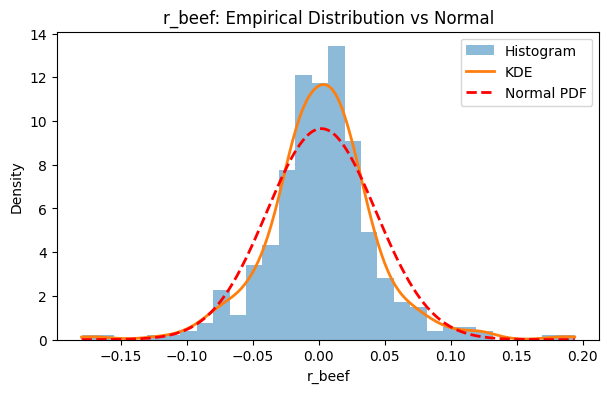

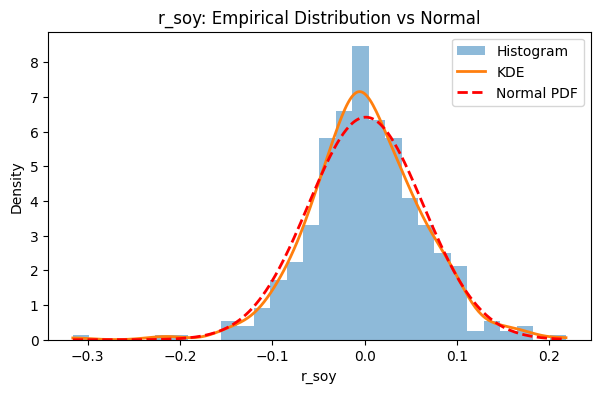

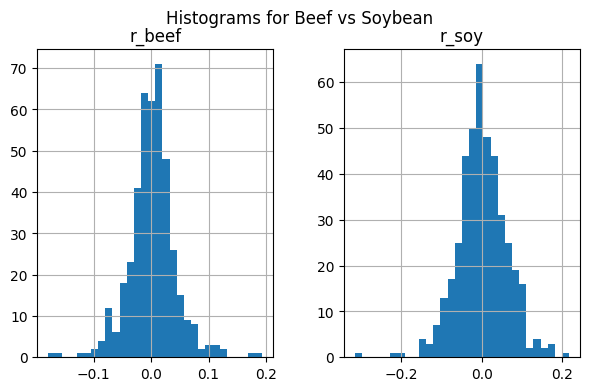

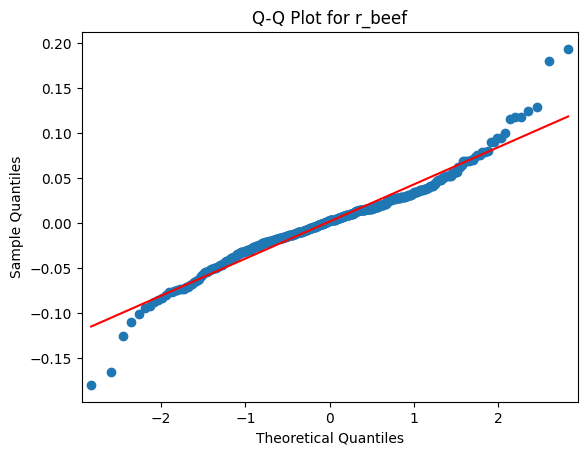

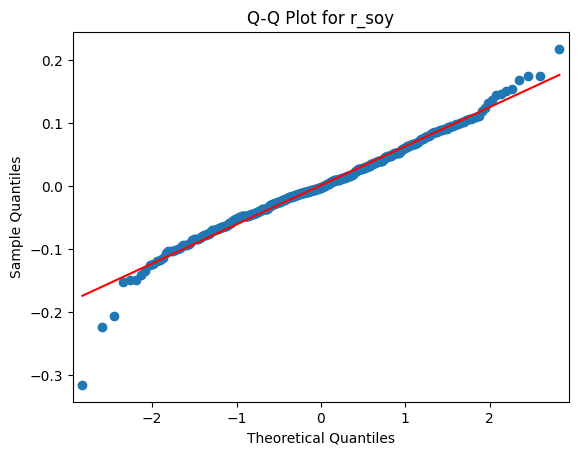

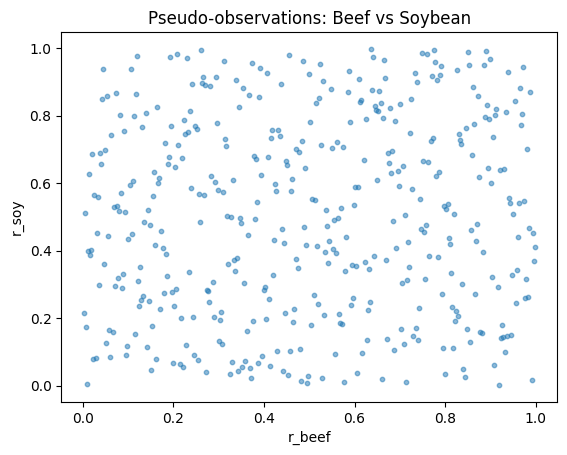


Rank dependence:
Kendall tau: 0.04811347454832436
Spearman rho: 0.07380313242731605

Copula Model Comparison:
Model        Param        LogLik       AIC          BIC         
Gaussian     0.0724       1.0637       -0.1274      3.9247      
Clayton      0.0605       0.6060       0.7880       4.8401      
Gumbel       1.0000       -172.6681    347.3363     351.3884    


==================== Corn vs Soybean ====================

Summary Statistics:
        count      mean       std       min       25%       50%       75%  \
r_corn  425.0  0.001445  0.058109 -0.251764 -0.028591  0.001687  0.036196   
r_soy   425.0  0.001159  0.062157 -0.316084 -0.036789 -0.002566  0.038924   

             max  
r_corn  0.219659  
r_soy   0.217934  

Covariance:
           r_corn     r_soy
r_corn  0.003377  0.001771
r_soy   0.001771  0.003864

Correlation:
           r_corn     r_soy
r_corn  1.000000  0.490252
r_soy   0.490252  1.000000

Normality (Jarque-Bera):
r_corn: p = 0.0
r_soy: p = 0.0

Empirical 

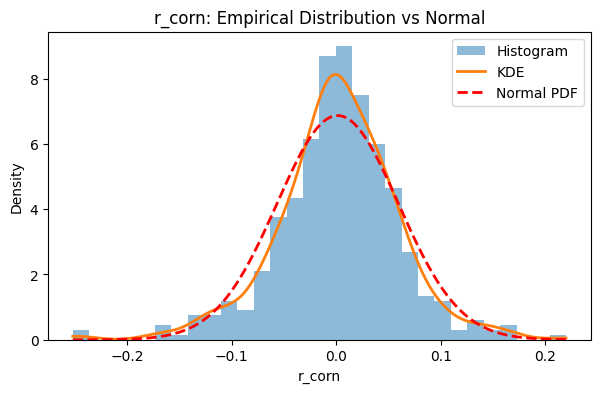

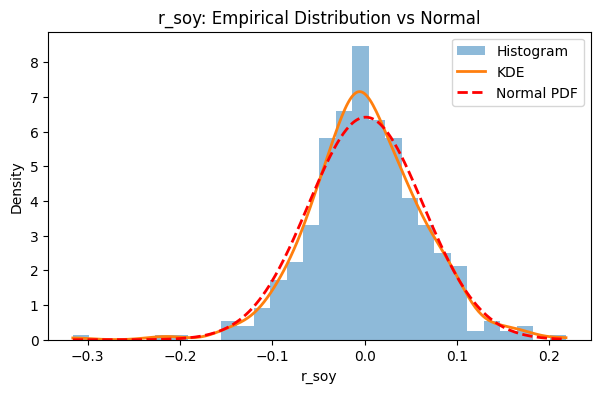

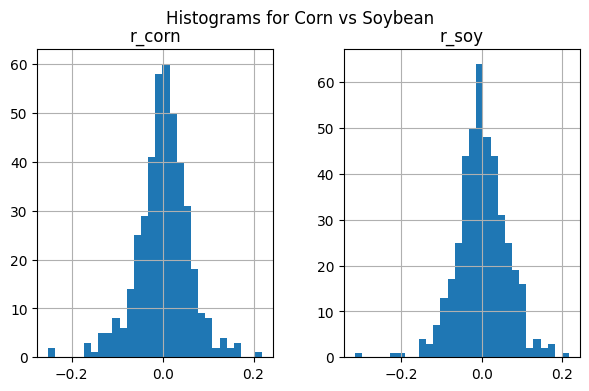

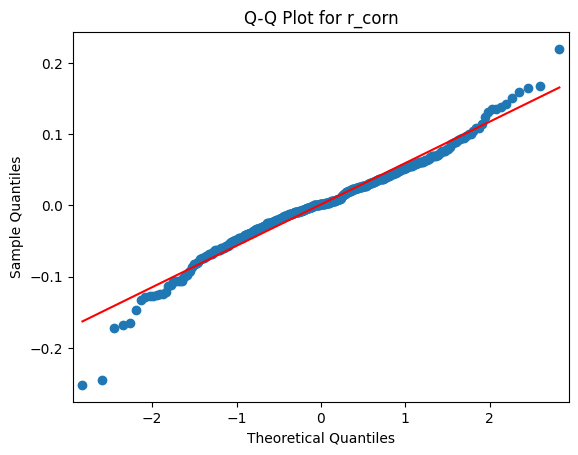

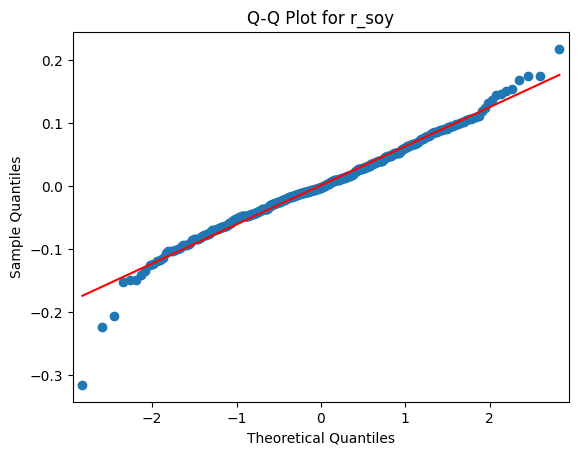

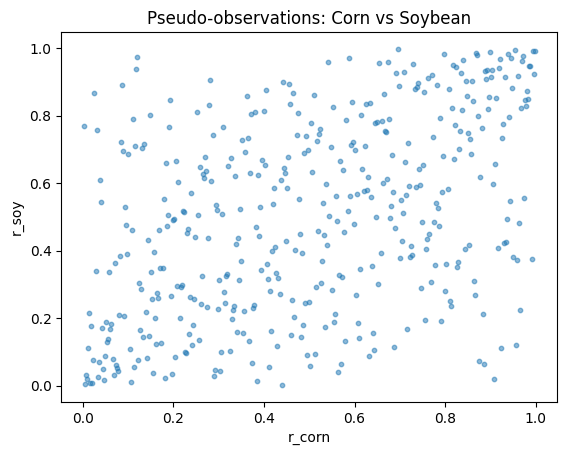


Rank dependence:
Kendall tau: 0.3212652608213097
Spearman rho: 0.4543327445248629

Copula Model Comparison:
Model        Param        LogLik       AIC          BIC         
Gaussian     0.4955       57.8341      -113.6683    -109.6162   
Clayton      0.7361       47.5713      -93.1425     -89.0905    
Gumbel       1.1271       -113.8177    229.6354     233.6875    


In [26]:
analyze_pair(pair_list["beef_corn"], name="Beef vs Corn")
analyze_pair(pair_list["beef_soy"],  name="Beef vs Soybean")
analyze_pair(pair_list["corn_soy"], name="Corn vs Soybean")

## Interpretation of Results

### Empirical MGF Analysis

The empirical Moment Generating Function (MGF) $M_X(t) = E[e^{tX}]$ was computed for each return series:

#### Beef Returns (r_beef)
| t      | -0.50  | -0.25  | 0.00   | 0.25   | 0.50   |
|--------|--------|--------|--------|--------|--------|
| MGF    | 0.9992 | 0.9995 | 1.0000 | 1.0006 | 1.0012 |

#### Corn Returns (r_corn)
| t      | -0.50  | -0.25  | 0.00   | 0.25   | 0.50   |
|--------|--------|--------|--------|--------|--------|
| MGF    | 0.9997 | 0.9997 | 1.0000 | 1.0005 | 1.0011 |

#### Soybean Returns (r_soy)
| t      | -0.50  | -0.25  | 0.00   | 0.25   | 0.50   |
|--------|--------|--------|--------|--------|--------|
| MGF    | 0.9999 | 0.9998 | 1.0000 | 1.0004 | 1.0011 |

**Key Observations:**
1. **Symmetry**: MGF values are approximately symmetric around t=0 (e.g., beef: 0.9992 at t=-0.5 vs 1.0012 at t=0.5), indicating the distributions are not heavily skewed.

2. **Deviation from Normality**: For a normal distribution with mean≈0 and variance σ², the theoretical MGF is $e^{t^2\sigma^2/2}$. The observed empirical MGF values show slight deviations from this formula, confirming the non-normality detected by Jarque-Bera tests (all p-values < 0.001).

3. **Fat Tails**: The empirical MGF values at t=±0.5 are slightly higher than what a normal distribution would predict, indicating fatter tails (higher probability of extreme events).

### Copula Model Selection (MLE Results)

**Rule**: Lower AIC/BIC indicates better model fit.

#### Beef vs Corn (Weak Dependence)
- **Winner: Gaussian Copula** (AIC = 0.72, BIC = 4.78)
- ρ = 0.056 (very weak linear dependence)
- **Interpretation**: The relationship is symmetric and weak. Clayton and Gumbel copulas perform poorly because there's minimal tail dependence to capture.

#### Beef vs Soybean (Weak Dependence)
- **Winner: Gaussian Copula** (AIC = -0.13, BIC = 3.92)
- ρ = 0.072 (very weak linear dependence)
- **Interpretation**: Similar to beef-corn, the weak symmetric dependence is best captured by the Gaussian copula. Beef prices are largely independent of feed crop prices.

#### Corn vs Soybean (Strong Dependence) 
- **Winner: Gaussian Copula** (AIC = -113.67, BIC = -109.62)
- ρ = 0.496 (moderate-strong linear dependence)
- Clayton copula (AIC = -93.14) shows lower-tail dependence exists
- **Interpretation**: Corn and soybean exhibit strong positive dependence as competing crops. The Gaussian copula fits best, though Clayton's reasonable performance suggests some asymmetry (joint downside movements). This strong co-movement reflects shared market drivers: weather, planting decisions, biofuel demand, and farmer crop substitution decisions.

**Economic Insight**: The copula analysis reveals that:
1. Beef is relatively isolated from feed price movements in short-term returns
2. Crop commodities (corn-soy) are highly interconnected and provide limited diversification benefits
3. For risk management, beef-crop portfolios offer genuine diversification, while corn-soy portfolios face significant joint downside risk